# Louvain Method Demonstration

This is a demonstration of the implementation of a modularity maximization algorithm that is used for community detection and is better known as the [Louvain Method](https://en.wikipedia.org/wiki/Louvain_modularity)

In [1]:
from louvain_method import louvain

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import time
from community import modularity
import pandas as pd
import numpy as np

matplotlib_axes_logger.setLevel('ERROR')

### Implementation of the Louvain method

We import the function of the algorithm implementation through the `louvain_method` module. The function takes as a positional argument the data in the form of a **networkx graph** and returns a dictionary with all the graph nodes as keys and their assigned community as value.

Additionally, there are two optional arguments:
* `visualize` boolean argument produces the intermediate aggregated nodes subgraphs
* `tol` argument sets a tolerance threshold in the path of the maximization of the modularity.


In [2]:
start = time.time()
time.time() - start

3.62396240234375e-05

### Preparing the experiments

Setting up the graph parameters for the experiments. Five different datasets are going to be tasted:
* Zachary's karate club
* jazz
* contiguous-usa
* euroroad
* dolphins

In [3]:
settings_karate = {
                'path': '../SNA_Project/GC/karate.csv',
                'delimiter': None,
                'create_using':nx.Graph(),
                'node_type':int,
                'edge_type':None,
                'encoding':'utf-8',
                'edge_attr': 'weight'
            }

settings_jazz = {
                'path': '../SNA_Project/GC/jazz.txt',
                'delimiter': None,
                'create_using':nx.Graph(),
                'node_type':int,
                'edge_type':None,
                'encoding':'utf-8',
                'edge_attr': 'weight'
            }

settings_usa = {
                'path': '../SNA_Project/GC/contiguous-usa.txt',
                'delimiter': None,
                'create_using':nx.Graph(),
                'node_type':int,
                'edge_type':None,
                'encoding':'utf-8',
                'edge_attr': 'weight'
            }

settings_euroroad = {
                'path': '../SNA_Project/GC/euroroad.txt',
                'delimiter': None,
                'create_using':nx.Graph(),
                'node_type':int,
                'edge_type':None,
                'encoding':'utf-8',
                'edge_attr': 'weight'
            }

# Create temporary csv file to handle 
dolphin_df = pd.read_csv('../SNA_Project/GC/dolphins.csv')
dolphin_df[['target', 'source']].to_csv('tmp_dolphins.csv', sep=' ', header=False, index=False)

settings_dolphins = {
                'path': 'tmp_dolphins.csv',
                'delimiter': None,
                'create_using':nx.Graph(),
                'node_type':int,
                'edge_type':None,
                'encoding':'utf-8',
                'edge_attr': None
            }

karate_g = nx.read_edgelist(path=settings_karate['path'],
                            delimiter=settings_karate['delimiter'], 
                            create_using=settings_karate['create_using'], 
                            nodetype=settings_karate['node_type'], 
                            data=True, 
                            edgetype=settings_karate['edge_type'], 
                            encoding=settings_karate['encoding'])

jazz_g = nx.read_edgelist(path=settings_jazz['path'],
                            delimiter=settings_jazz['delimiter'], 
                            create_using=settings_jazz['create_using'], 
                            nodetype=settings_jazz['node_type'], 
                            data=True, 
                            edgetype=settings_jazz['edge_type'], 
                            encoding=settings_jazz['encoding'])

contiguous_usa_g = nx.read_edgelist(path=settings_usa['path'],
                            delimiter=settings_usa['delimiter'], 
                            create_using=settings_usa['create_using'], 
                            nodetype=settings_usa['node_type'], 
                            data=True, 
                            edgetype=settings_usa['edge_type'], 
                            encoding=settings_usa['encoding'])


euroroad_g = nx.read_edgelist(path=settings_euroroad['path'],
                            delimiter=settings_euroroad['delimiter'], 
                            create_using=settings_euroroad['create_using'], 
                            nodetype=settings_euroroad['node_type'], 
                            data=True, 
                            edgetype=settings_euroroad['edge_type'], 
                            encoding=settings_euroroad['encoding'])




dolphins_g = nx.read_edgelist(path='tmp_dolphins.csv',
                            delimiter=settings_dolphins['delimiter'], 
                            create_using=settings_dolphins['create_using'], 
                            nodetype=settings_dolphins['node_type'], 
                            data=True, 
                            edgetype=settings_dolphins['edge_type'], 
                            encoding=settings_dolphins['encoding'])
# Remove tmp dolphins dataset file
import os; os.remove('tmp_dolphins.csv') 

# Dictionary to collect the results
result_dict = {
                'dataset': [],
                'community_no': [],
                'modularity': [],
                'silhouette': [],
                'time': []
                }

In [4]:
karate_g.has_edge(6,16)

True

### Evaluation

We evaluate the quality of our clusters by using the modularity metric, implemented as the `community.modularity` module and a custom implementation of the silhouette score, as proposed in Stanfords' [Community Detection Using Graph Structure and Semantic Understanding of Text](https://stanford.edu/~kartiks2/community_detection.pdf)

The silhouette score is given by the comparing the average distance of a given node inside his community against the smallest average distance with the other communities. We consider the maximum value of the coefficient created by this comparison as the *silhouette score* as defined by [Kaufman et al.](https://en.wikipedia.org/wiki/Silhouette_(clustering)#cite_note-3) .

In [5]:
def silhouette_score(communities, G):
    clusters = list(set(communities.values()))
    nodes = list(communities.keys())
    
    # Create the transposed communities dict
    communities_t = {c:[] for c in clusters}
    for node in nodes:
        communities_t[communities[node]].append(node)
    
    sil_coef = []
    
    for node in nodes:
        # calculate average inner distance: a(u)
        a = np.mean([ nx.shortest_path_length(G,source=node,target=n) 
                      for n in communities_t[communities[node]] ])
        
        # calculate minimum average outer distance: b(u)
        mean_outer_distances = []
        for c in clusters:            
            for n in communities_t[c]:   
                outer_distance = []
                if communities[node] != communities[n]:
                    outer_distance = []
                    # in case there is no path from node to n
                    try:
                        outer_distance.append(nx.shortest_path_length(G,source=node,target=n))
                    except nx.NetworkXNoPath:
                        pass
            if outer_distance:        
                mean_outer_distances.append(np.mean(outer_distance))
                
        if mean_outer_distances:
            b = np.min(mean_outer_distances)
            # calculate silhouette coefficient
            sil_coef.append( (b-a)/max(a,b) )
    
    # In case the dataset is homogenized
    if sil_coef:
        return np.round(sil_coef, 3), np.round(max(sil_coef), 3)
    else:
        return sil_coef,1

#### 1.  Zachary's karate Club dataset

The famous Zachary's Karate Club dataset.

/home/arvartho/python/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Finished community detection in 0:00:00.055101


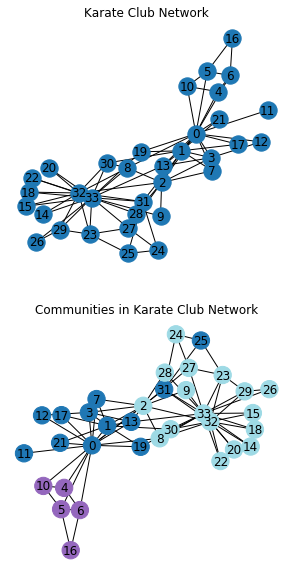

In [6]:
# Draw initial graph
G = karate_g

fig = plt.figure(figsize=(5, 10))
ax1 =  fig.add_subplot(211)
ax1.set_title('Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               with_labels=True)

# Execute Louvain's algorithm
start = time.time()
communities = louvain(G.copy())
elapsed_time = time.time()-start

#Draw community graph
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values, 
               with_labels=True)
plt.show()  

# Record results
result_dict['dataset'].append('Zachary\'s Karate Club')
result_dict['community_no'].append(len(set(communities.values())))
result_dict['modularity'].append(modularity(communities, G))
result_dict['silhouette'].append(silhouette_score(communities, G)[1])
result_dict['time'].append(elapsed_time)


#### Intermediate visualizations: Zachary's karate Club Visualization

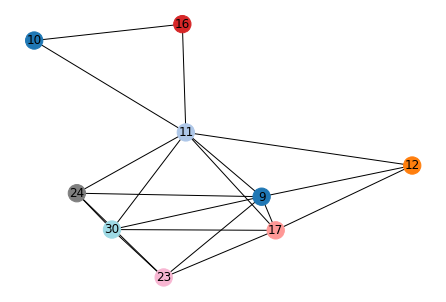

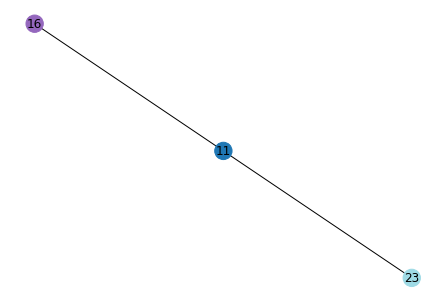

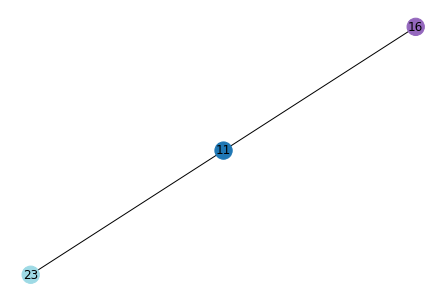

Finished community detection in 0:00:00.376894


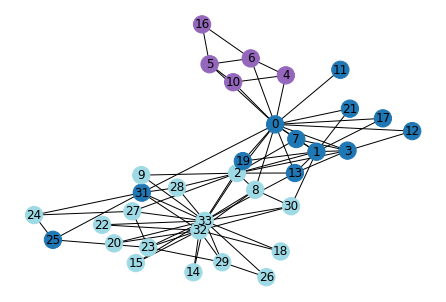

In [7]:
G = karate_g

fig = plt.figure()

# Execute Louvain's algorithm
communities = louvain(G.copy(), visualize=True)

#Visualize final communities
values = [communities[node] for node in G.nodes()]            

fig.suptitle('Communities in Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values, 
               with_labels=True)
plt.show()           


#### 2.  Jazz musicians dataset


Finished community detection in 0:00:19.853020


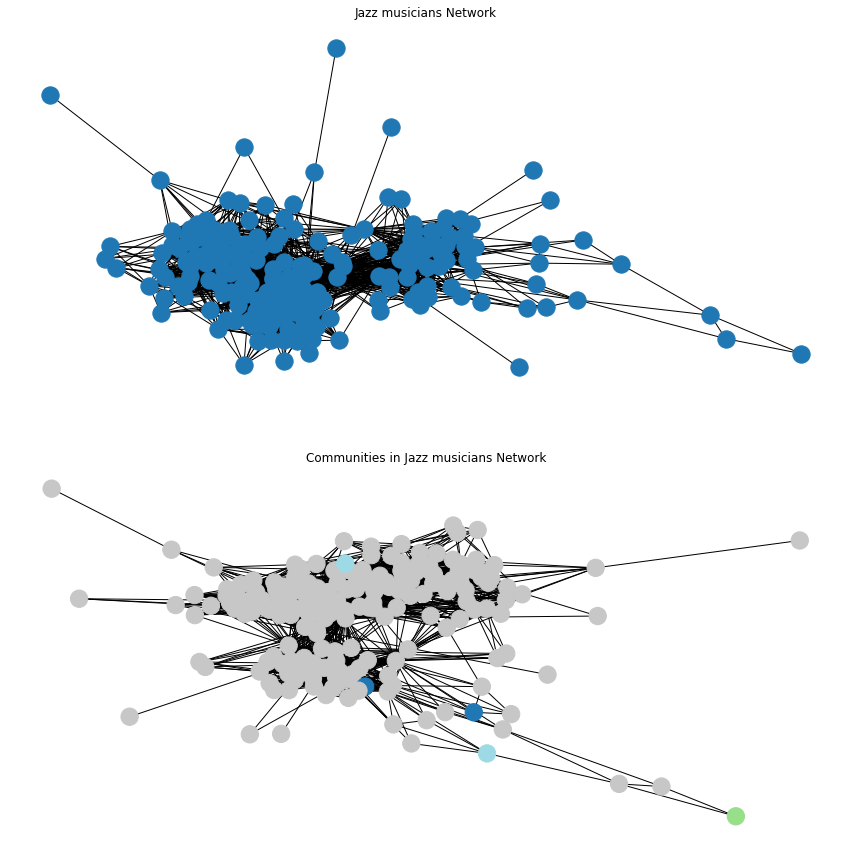

In [8]:
G = jazz_g

fig = plt.figure(figsize=(15, 15))
ax1 =  fig.add_subplot(211)
ax1.set_title('Jazz musicians Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'))

# Execute Louvain's algorithm
start = time.time() 
communities = louvain(G.copy())
elapsed_time = time.time()-start

#Visualize final communities
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Jazz musicians Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values)
plt.show()  

# Record results
result_dict['dataset'].append('Jazz musicians')
result_dict['community_no'].append(len(set(communities.values())))
result_dict['modularity'].append(modularity(communities, G))
result_dict['silhouette'].append(silhouette_score(communities, G)[1])
result_dict['time'].append(elapsed_time)

#### 3.  Contiguous USA dataset

Finished community detection in 0:00:00.095031


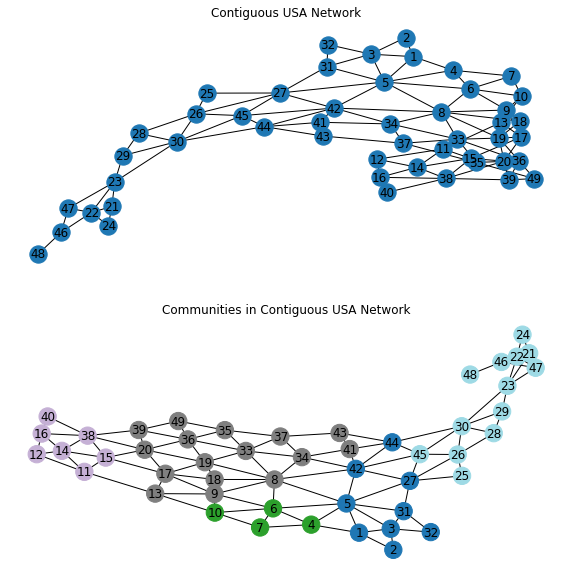

In [9]:
G = contiguous_usa_g

fig = plt.figure(figsize=(10, 10))
ax1 =  fig.add_subplot(211)
ax1.set_title('Contiguous USA Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               with_labels=True)

# Execute Louvain's algorithm
start = time.time() 
communities = louvain(G.copy())
elapsed_time = time.time()-start

#Visualize final communities
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Contiguous USA Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values, 
               with_labels=True)
plt.show()  

# Record results
result_dict['dataset'].append('Contiguous USA')
result_dict['community_no'].append(len(set(communities.values())))
result_dict['modularity'].append(modularity(communities, G))
result_dict['silhouette'].append(silhouette_score(communities, G)[1])
result_dict['time'].append(elapsed_time)

#### 4.  Euroroad

In [ ]:
G = euroroad_g

fig = plt.figure(figsize=(15, 15))
ax1 =  fig.add_subplot(211)
ax1.set_title('Euroroad Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'))

# Execute Louvain's algorithm
start = time.time() 
communities = louvain(G.copy())
elapsed_time = time.time()-start

#Visualize final communities
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Euroroad Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values)
plt.show()  

# Record results
result_dict['dataset'].append('Euroroad')
result_dict['community_no'].append(len(set(communities.values())))
result_dict['modularity'].append(modularity(communities, G))
result_dict['silhouette'].append(silhouette_score(communities, G)[1])
result_dict['time'].append(elapsed_time)

#### 5. Dolphins dataset

In [ ]:
G = dolphins_g

fig = plt.figure(figsize=(10, 10))
ax1 =  fig.add_subplot(211)
ax1.set_title('Dolphins Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'))

# Execute Louvain's algorithm
start = time.time() 
communities = louvain(G.copy())
elapsed_time = time.time()-start

#Visualize final communities
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Dolphins Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values)
plt.show()  

# Record results
result_dict['dataset'].append('Dolphins')
result_dict['community_no'].append(len(set(communities.values())))
result_dict['modularity'].append(modularity(communities, G))
result_dict['silhouette'].append(silhouette_score(communities, G)[1])
result_dict['time'].append(elapsed_time)

In [ ]:
results_data = {
                'dataset':result_dict['dataset'],
                'community_no':result_dict['community_no'],
                'modularity':result_dict['modularity'],
                'silhouette':result_dict['silhouette'],
                'time':result_dict['time']
                }
results_df = pd.DataFrame(data=results_data)
results_df

In [ ]:
data_columns = results_df.columns[-4:]
fig, ax = plt.subplots(nrows=1, 
                        ncols=len(data_columns),
                        figsize=(15,5))

for i,column in enumerate(data_columns):
    chart = sns.barplot(data=results_df, x='dataset', y=column, ax=ax[i])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
    chart.set_title(column)
